In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from plotly.subplots import make_subplots
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
#from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller

std=StandardScaler()
# set up everything so that the figures show up in the notebook
init_notebook_mode(connected=True)

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from warnings import catch_warnings, filterwarnings
from statsmodels.tools.eval_measures import rmse, aic

filterwarnings('ignore')

# Indeed data modeling

## Load data

In [3]:
df_indeed = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/Indeed_SDEJobs_20200802_combined.csv')
df_indeed.head()

,Title,Company,State,Location,Date,Salary,Summary,Description,Code,Post date,Day of week,City,Date in num
0,Backend Software Engineer,PayPal,Alabama,"Montgomery, AL 36101",1 day ago,NaN,Provide technical leadership and mentoring to ...,Experience in developing software for distribu...,AL,2020-08-01,Sat,Montgomery,NaN
1,Backend Software Engineer,PayPal,Alabama,"Montgomery, AL 36101",1 day ago,NaN,Provide technical leadership and mentoring to ...,Experience in developing software for distribu...,AL,2020-08-01,Sat,Montgomery,NaN
2,C++ Software Developer (Jr.),Brockwell Technologies,Alabama,"Huntsville, AL 35805",1 day ago,NaN,The candidate will perform development activit...,BTI is seeking mid to senior level C++ softwar...,AL,2020-08-01,Sat,Huntsville,NaN
3,UX Software Developer,Trideum Corporation,Alabama,"Birmingham, AL 35246",1 day ago,NaN,Experience with software systems engineering a...,Come and join Trideum Corporation's dynamic an...,AL,2020-08-01,Sat,Birmingham,NaN
4,C++ Software Developer (Mid-Level),Brockwell Technologies,Alabama,"Huntsville, AL 35805",1 day ago,NaN,The candidate will perform development activit...,BTI is seeking mid to senior level C++ softwar...,AL,2020-08-01,Sat,Huntsville,NaN


In [4]:
bydate = df_indeed.groupby('Post date').size()

df_date_indeed = pd.DataFrame({'Date': bydate.index, 'Jobnums': bydate.values})

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_date_indeed['Date'], y=df_date_indeed['Jobnums'], mode='lines+markers'))

fig.update_layout(title='Data scientist open positions vs. post date')
fig.show()

In [6]:
df_date_indeed['Date'] = pd.to_datetime(df_date_indeed['Date'])
df_date_indeed.set_index('Date', drop=False, inplace=True)

In [7]:
week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_date_indeed['Day of week'] = df_date_indeed['Date'].apply(lambda x: week[x.weekday()])

In [8]:
df_date_indeed['Weekend'] = df_date_indeed['Day of week'].apply(lambda x: 1 if (x == 'Sun') or (x == 'Sat') else 0)

In [9]:
df_date_indeed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2020-06-12 to 2020-08-02
Data columns (total 4 columns):
Date           52 non-null datetime64[ns]
Jobnums        52 non-null int64
Day of week    52 non-null object
Weekend        52 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.0+ KB


Text(0.5, 0, ' ')

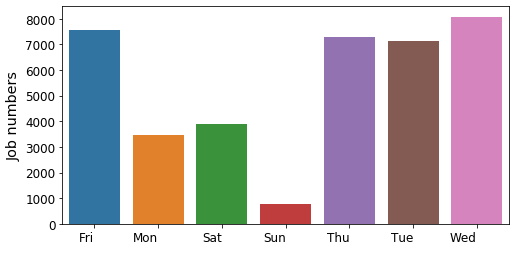

In [10]:
by_weekday = df_date_indeed.groupby('Day of week').sum()
by_weekday.reset_index(inplace=True)
by_weekday

plt.figure(figsize=(8,4))
sns.barplot(x='Day of week', y='Jobnums', data=by_weekday)
plt.xticks(horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='x-large')
plt.xlabel(' ')

## Load Covid-19 Data

In [11]:
df_covid = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/covid_19_data.csv')
df_covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [12]:
df_us = df_covid[df_covid['Country/Region']=='US'].reset_index(drop=True)
df_us['ObservationDate'] = pd.to_datetime(df_us['ObservationDate'])
bydate_us = df_us.groupby('ObservationDate').sum()
bydate_us.drop('SNo', axis=1, inplace=True)

In [13]:
bydate_us['Active'] = bydate_us['Confirmed'] - bydate_us['Deaths'] - bydate_us['Recovered']
bydate_us['New'] = bydate_us['Confirmed'].diff()
bydate_us.at['2020-01-22','New'] = 0.0
bydate_us['Fatality'] = bydate_us['Deaths']/bydate_us['Confirmed']*100

In [14]:
bydate_us

,Confirmed,Deaths,Recovered,Active,New,Fatality
ObservationDate,,,,,,
2020-01-22,1.0,0.0,0.0,1.0,0.0,0.000000
2020-01-23,1.0,0.0,0.0,1.0,0.0,0.000000
2020-01-24,2.0,0.0,0.0,2.0,1.0,0.000000
2020-01-25,2.0,0.0,0.0,2.0,0.0,0.000000
2020-01-26,5.0,0.0,0.0,5.0,3.0,0.000000
...,...,...,...,...,...,...
2020-08-03,4713540.0,155402.0,1513446.0,3044692.0,45585.0,3.296928
2020-08-04,4771080.0,156801.0,1528979.0,3085300.0,57540.0,3.286489
2020-08-05,4823890.0,158250.0,1577851.0,3087789.0,52810.0,3.280547


In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Confirmed'], mode='lines', name='Confirmed'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Deaths'], mode='lines', name='Deaths'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Recovered'], mode='lines', name='Recovered'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Active'], mode='lines', name='Active'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['New'], mode='lines', name='New'))
fig.add_trace(go.Scatter(x=bydate_us.index, y=bydate_us['Fatality'], mode='lines', name='Fatality Rate'))

fig.update_layout(title='US COVID-19 Cases')
fig.show()

## Combine Data

In [16]:
df_covid_trunc1 = bydate_us['2020-06-12':'2020-08-02']
df_indeed_trunc = df_date_indeed['2020-06-12':'2020-08-02']

df_combined_indeed = pd.concat([df_indeed_trunc, df_covid_trunc1], axis=1)
df_combined_indeed.head()

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
2020-06-12,2020-06-12,282,Fri,0,2048986.0,114669.0,547386.0,1386931.0,25639.0,5.596378
2020-06-13,2020-06-13,330,Sat,1,2074526.0,115436.0,556606.0,1402484.0,25540.0,5.564452
2020-06-14,2020-06-14,61,Sun,1,2094058.0,115732.0,561816.0,1416510.0,19532.0,5.526686
2020-06-15,2020-06-15,227,Mon,0,2114026.0,116127.0,576334.0,1421565.0,19968.0,5.493168
2020-06-16,2020-06-16,576,Tue,0,2137731.0,116963.0,583503.0,1437265.0,23705.0,5.471362


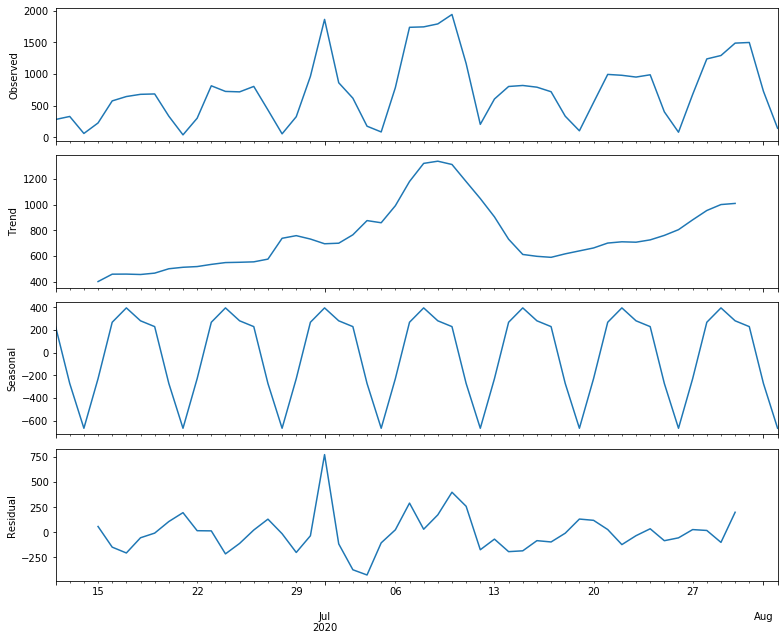

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

y=df_combined_indeed['Jobnums']
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Grid Search

In [18]:
def diff_transform(df_train,  d):
    """take difference"""
    df_diff = df_train.copy()
    columns = df_train.columns
    if d>0:
        for col in columns:        
            df_diff[str(col)+'_1d'] = df_diff[col].diff().fillna(0)
            df_diff.drop(columns=[col],inplace=True)
            if d>1:
                df_diff[str(col)+'_2d'] = df_diff[str(col)+'_1d'].diff().fillna(0)
                df_diff.drop(columns=[str(col)+'_1d'],inplace=True)
            
    return df_diff

In [19]:
def invert_transform(df_train, df_forecast, d):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    if d>0:
        for col in columns:        
            # Roll back 2nd Diff
            if d==2:
                df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
                df_fc.drop(columns=[str(col)+'_2d'],inplace=True)
            # Roll back 1st Diff
            df_fc[col] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
            df_fc.drop(columns=[str(col)+'_1d'],inplace=True)
    return df_fc

In [20]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def measure_rmse(actual, predicted):
    return rmse(actual, predicted)

def varmax_forecast(train, test_len, config, exog1=None, exog2=None):
    order, trend, d= config
    #d parameter to take difference
    df_diff = diff_transform(train,  d)
    try:
        model = VARMAX(df_diff, order=order, trend=trend, exog=exog1, initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        yhat_diff = model_fit.forecast(steps=test_len, exog=exog2)
        yhat = invert_transform(train, yhat_diff, d)
    except:
        yhat = None
    return yhat

def single_validation(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        yhat = varmax_forecast(train, len(test), cfg, exog1=exog_train, exog2=exog_test)
    else:
        yhat = varmax_forecast(train, len(test), cfg)
    if yhat is not None:
        error = measure_rmse(test['Jobnums'], yhat['Jobnums'])
    else:
        error = None
    return error

def walk_forward_validation(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    predictions = pd.DataFrame()
    history = train.copy()
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        exog_ = [x[:] for x in exog_train.values]
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
            exog_.append(np.array(exog_test.iloc[i]))
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return error
    else:
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg)
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return error

def score_model(data, n_test, cfg, method, exog=None, debug=True):
    result = None
    key = str(cfg)
    if debug:
        if method=='walk':
            result = walk_forward_validation(data, n_test, cfg, exog)
        else:
            result = single_validation(data, n_test, cfg, exog)
    else:
        try:
            with catch_warnings():
                filterwarnings("ignore")
                if method=='walk':
                    result = walk_forward_validation(data, n_test, cfg, exog)
                else:
                    result = single_validation(data, n_test, cfg, exog)
        except:
            error = None
    if result is not None:
        print('---> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(data, cfg_list, n_test, method, exog=None, parallel=True):
    scores = None
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg, method, exog) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg, method, exog) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

def varmax_configs():
    models = list()
    p_params = [3, 4, 5, 6, 7, 8, 9, 10]
    q_params = [0, 1, 2]
    t_params = ['n', 'c', 't', 'ct']
    d_params = [0, 1, 2]
    
    for p in p_params:
        for q in q_params:
            for t in t_params:
                for d in d_params:
                    cfg = [(p,q), t, d]
                    models.append(cfg)
    return models

In [21]:
def walk_forward_best(data, n_test, cfg, exog=None):
    train, test = train_test_split(data, n_test)
    predictions = pd.DataFrame()
    history = train.copy()
    if exog is not None:
        exog_train, exog_test = train_test_split(exog, n_test)
        exog_ = [x[:] for x in exog_train.values]
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
            exog_.append(np.array(exog_test.iloc[i]))
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return predictions, error
    else:
        for i in range(len(test)):
            yhat = varmax_forecast(history, 1, cfg)
            predictions = predictions.append(yhat)
            history = history.append(test.iloc[i])
        error = measure_rmse(test['Jobnums'], predictions['Jobnums'])
        return predictions, error

#### No eXog + Walk

In [22]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_indeed[['New','Jobnums']], cfg_list, n_test, method, exog=None, parallel=False)
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))

---> Model[[(3, 0), 'n', 0]] 350.734
---> Model[[(3, 0), 'n', 1]] 492.777
---> Model[[(3, 0), 'n', 2]] 615.051
---> Model[[(3, 0), 'c', 0]] 357.137
---> Model[[(3, 0), 'c', 1]] 529.812
---> Model[[(3, 0), 'c', 2]] 615.149
---> Model[[(3, 0), 't', 0]] 380.682
---> Model[[(3, 0), 't', 1]] 535.391
---> Model[[(3, 0), 't', 2]] 632.641
---> Model[[(3, 0), 'ct', 0]] 450.076
---> Model[[(3, 0), 'ct', 1]] 537.971
---> Model[[(3, 0), 'ct', 2]] 629.137
---> Model[[(3, 1), 'n', 0]] 359.047
---> Model[[(3, 1), 'n', 1]] 424.749
---> Model[[(3, 1), 'n', 2]] 538.536
---> Model[[(3, 1), 'c', 0]] 390.284
---> Model[[(3, 1), 'c', 1]] 495.343
---> Model[[(3, 1), 'c', 2]] 520.422
---> Model[[(3, 1), 't', 0]] 360.413
---> Model[[(3, 1), 't', 1]] 512.307
---> Model[[(3, 1), 't', 2]] 543.866
---> Model[[(3, 1), 'ct', 0]] 402.844
---> Model[[(3, 1), 'ct', 1]] 494.913
---> Model[[(3, 1), 'ct', 2]] 566.529
---> Model[[(3, 2), 'n', 0]] 383.710
---> Model[[(3, 2), 'n', 1]] 397.400
---> Model[[(3, 2), 'n', 2]] 574

---> Model[[(9, 0), 'c', 1]] 442.359
---> Model[[(9, 0), 'c', 2]] 494.399
---> Model[[(9, 0), 't', 0]] 284.400
---> Model[[(9, 0), 't', 1]] 453.199
---> Model[[(9, 0), 't', 2]] 505.900
---> Model[[(9, 0), 'ct', 0]] 360.186
---> Model[[(9, 0), 'ct', 1]] 442.113
---> Model[[(9, 0), 'ct', 2]] 495.779
---> Model[[(9, 1), 'n', 0]] 341.023
---> Model[[(9, 1), 'n', 1]] 439.664
---> Model[[(9, 1), 'n', 2]] 505.037
---> Model[[(9, 1), 'c', 0]] 412.563
---> Model[[(9, 1), 'c', 1]] 449.878
---> Model[[(9, 1), 'c', 2]] 495.055
---> Model[[(9, 1), 't', 0]] 295.990
---> Model[[(9, 1), 't', 1]] 451.089
---> Model[[(9, 1), 't', 2]] 499.203
---> Model[[(9, 1), 'ct', 0]] 359.315
---> Model[[(9, 1), 'ct', 1]] 435.122
---> Model[[(9, 1), 'ct', 2]] 495.163
---> Model[[(9, 2), 'n', 0]] 371.895
---> Model[[(9, 2), 'n', 1]] 448.138
---> Model[[(9, 2), 'n', 2]] 507.370
---> Model[[(9, 2), 'c', 0]] 379.342
---> Model[[(9, 2), 'c', 1]] 434.502
---> Model[[(9, 2), 'c', 2]] 504.488
---> Model[[(9, 2), 't', 0]] 265

In [42]:
best_cfg = [(9, 2), 't', 0]
n_test = 7
indeed_data = df_combined_indeed[['New','Jobnums']]
train, test = train_test_split(indeed_data, n_test)
yhat_varma, error = walk_forward_best(indeed_data, n_test, best_cfg)

#### X=weekend + Walk

In [23]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_indeed[['New','Jobnums']], cfg_list, n_test, method, exog=df_combined_indeed[['Weekend']])
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))

---> Model[[(3, 0), 'n', 1]] 338.615
---> Model[[(3, 0), 'n', 2]] 543.558
---> Model[[(3, 0), 'n', 0]] 275.021
---> Model[[(3, 0), 'c', 0]] 252.424
---> Model[[(3, 0), 'c', 1]] 197.003
---> Model[[(3, 0), 'c', 2]] 523.515
---> Model[[(3, 0), 't', 0]] 312.920
---> Model[[(3, 0), 't', 1]] 277.230
---> Model[[(3, 0), 't', 2]] 570.018
---> Model[[(3, 0), 'ct', 0]] 367.550
---> Model[[(3, 0), 'ct', 1]] 157.545
---> Model[[(3, 0), 'ct', 2]] 528.608
---> Model[[(3, 1), 'n', 0]] 281.873
---> Model[[(3, 1), 'n', 2]] 457.896
---> Model[[(3, 1), 'n', 1]] 348.135
---> Model[[(3, 1), 'c', 0]] 285.102
---> Model[[(3, 1), 'c', 1]] 121.290
---> Model[[(3, 1), 't', 0]] 291.274
---> Model[[(3, 1), 'c', 2]] 495.679
---> Model[[(3, 1), 't', 1]] 275.634
---> Model[[(3, 1), 't', 2]] 419.120
---> Model[[(3, 1), 'ct', 0]] 291.717
---> Model[[(3, 1), 'ct', 1]] 152.665
---> Model[[(3, 1), 'ct', 2]] 503.338
---> Model[[(3, 2), 'n', 0]] 304.162
---> Model[[(3, 2), 'n', 1]] 334.048
---> Model[[(3, 2), 'n', 2]] 463

---> Model[[(9, 0), 'c', 1]] 211.078
---> Model[[(9, 0), 'c', 2]] 459.521
---> Model[[(9, 0), 't', 0]] 309.311
---> Model[[(9, 0), 't', 1]] 334.553
---> Model[[(9, 0), 't', 2]] 441.036
---> Model[[(9, 0), 'ct', 0]] 313.674
---> Model[[(9, 0), 'ct', 1]] 327.025
---> Model[[(9, 0), 'ct', 2]] 487.261
---> Model[[(9, 1), 'n', 0]] 287.558
---> Model[[(9, 1), 'n', 1]] 452.472
---> Model[[(9, 1), 'n', 2]] 453.727
---> Model[[(9, 1), 'c', 0]] 264.342
---> Model[[(9, 1), 'c', 1]] 262.708
---> Model[[(9, 1), 'c', 2]] 405.917
---> Model[[(9, 1), 't', 0]] 277.800
---> Model[[(9, 1), 't', 1]] 375.680
---> Model[[(9, 1), 't', 2]] 394.001
---> Model[[(9, 1), 'ct', 0]] 317.697
---> Model[[(9, 1), 'ct', 1]] 372.175
---> Model[[(9, 1), 'ct', 2]] 481.652
---> Model[[(9, 2), 'n', 0]] 432.138
---> Model[[(9, 2), 'n', 1]] 430.562
---> Model[[(9, 2), 'n', 2]] 494.441
---> Model[[(9, 2), 'c', 0]] 254.516
---> Model[[(9, 2), 'c', 1]] 302.525
---> Model[[(9, 2), 't', 0]] 222.983
---> Model[[(9, 2), 'c', 2]] 468

In [43]:
n_test = 7
best_cfg = [(3, 1), 'c', 1]
indeed_data = df_combined_indeed[['New','Jobnums']]
train, test = train_test_split(indeed_data, n_test)
yhat_varmax, errorx = walk_forward_best(indeed_data, n_test, best_cfg, exog=df_combined_indeed[['Weekend']])

In [44]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    subplot_titles=("Train data",'No eXog, RMSE: {:0.2f}'.format(error), 'X=Weekend, RMSE: {:0.2f}'.format(errorx)))

fig.add_trace(go.Scatter(x=train.index, y=train['Jobnums'], mode='lines+markers',name='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers',line=dict(color='green'), name='Test', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=yhat_varma["Jobnums"], mode='lines+markers',line=dict(color='red'), name='Prediction',showlegend=False),row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,1], fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,3], fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers', line=dict(color='green'), name='Test',showlegend=True), row=2, col=2)
fig.add_trace(go.Scatter(x=test.index, y=yhat_varmax["Jobnums"], mode='lines+markers', line=dict(color='red'), name='Prediction',showlegend=True),row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_u, fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_l, fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=2)
fig.update_layout(title='Indeed Software Engineer Job Openings Forecast via VARMAX Model',legend=dict(x=1,y=0.25))
fig.show()

### Forecast the Future

In [51]:
df_indeed_future = pd.DataFrame(columns=['Date', 'Day of week', 'Weekend'])
df_indeed_future['Date'] = pd.date_range('2020-08-03', '2020-08-09')
df_indeed_future.set_index('Date', inplace=True, drop=False)
df_indeed_future['Day of week'] = df_indeed_future['Date'].apply(lambda x: week[x.weekday()])
df_indeed_future['Weekend'] = df_indeed_future['Day of week'].apply(lambda x: 1 if (x=='Sun') or (x=='Sat') else 0)
df_indeed_future

,Date,Day of week,Weekend
Date,,,
2020-08-03,2020-08-03,Mon,0
2020-08-04,2020-08-04,Tue,0
2020-08-05,2020-08-05,Wed,0
2020-08-06,2020-08-06,Thu,0
2020-08-07,2020-08-07,Fri,0
2020-08-08,2020-08-08,Sat,1
2020-08-09,2020-08-09,Sun,1


In [52]:
n_test = 7
best_cfg = [(3, 1), 'c', 1]
train = df_combined_indeed[['New','Jobnums']]
exog_train = df_combined_indeed[['Weekend']]
exog_test = df_indeed_future[['Weekend']]
indeed_pred = pd.DataFrame()
history = train.copy()
exog_ = [x[:] for x in exog_train.values]
for i in range(n_test):
    yhat = varmax_forecast(history, 1, best_cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
    indeed_pred = indeed_pred.append(yhat)
    history = history.append(yhat)
    exog_.append(np.array(exog_test.iloc[i]))

In [56]:
fig = go.Figure()

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=df_indeed_future.index[0],
            y0=0,
            x1=df_indeed_future.index[-1],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.2,
            layer="below",
            line_width=0,
        )
    ]
)

fig.add_trace(go.Scatter(x=df_combined_indeed.index, y=df_combined_indeed['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='royalblue'), name='Train'))

fig.add_trace(go.Scatter(x=df_indeed_future.index, y=indeed_pred['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='red'), name='Future Forecast'))
#fig.add_trace(go.Scatter(x=df_indeed_future.index, y=yhat_fcast['Jobnums'], mode='lines+markers', 
#                         marker=dict(size=8, color='green'), name='Future Forecast'))

# fig.add_trace(go.Scatter(x=df_indeed_future.index, y=pred_ci.iloc[:,1],
#                          fill='tonexty',
#                          mode='lines', line_color='lightgrey',line_width=0,
#                          showlegend=False))
# fig.add_trace(go.Scatter(x=df_indeed_future.index, y=pred_ci.iloc[:,0],
#                          fill='tonexty',
#                          mode='lines', line_color='grey', opacity=0.1, line_width=0,
#                          showlegend=False))

fig.add_annotation(
            x='2020-08-05',
            y=1600,
            text="Future<br>forecast",
            font=dict(size=16),
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=10,
            ay=-70,)

fig.update_layout(title={'text': "Indeed Software Engineer Open Positions Future Forecast (VARMAX Model)", 
                         'y':0.9, 'x':0.52,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900,
                  height=500,
                  titlefont=dict(size=20),
                  xaxis=dict(title=dict(text='Post date', standoff=0), titlefont=dict(size=18), tickfont=dict(size=16)),
                  yaxis=dict(title=dict(text='Job numbers'), titlefont=dict(size=18), tickfont=dict(size=16)),
                  legend=dict(font=dict(size=16), x=0.05, y=0.95),
                  margin = {'r':10, 'l': 0, 't':90, 'b':0}
                 )
fig.show()

# LinkedIn Data Modeling

## Load data

In [24]:
df_linkedin = pd.read_csv('/Users/tingtingweng/Documents/summer_intern/data/linkedin_se_080620_combined.csv')
df_linkedin.head()

,Title,Company,Location,Date,Seniority level,Employment type,Industry,Description,State,Code
0,JSIL Mid-Level Software Developer,"Modern Technology Solutions, Inc. (MTSI)","Huntsville, Alabama, United States",2020-08-06,Entry level,Full-time,"Defense & Space,Aviation & Aerospace,Military","OverviewModern Technology Solutions, Inc. (MTS...",Alabama,AL
1,Senior Software Engineer,Integrate,"Birmingham, Alabama, United States",2020-08-06,Mid-Senior level,Full-time,"Computer Software,Online Media,Marketing and A...","Integrate&nbsp;is a rapidly growing, venture-b...",Alabama,AL
2,Software Engineer,Integrate,"Birmingham, Alabama, United States",2020-08-06,Associate,Full-time,"Computer Software,Online Media,Marketing and A...","Integrate&nbsp;is a rapidly growing, venture-b...",Alabama,AL
3,Software Developer,"Cyberdata Technologies, Inc.","Tuscaloosa, Alabama, United States",2020-08-06,Entry level,Full-time,"Information Technology and Services,Computer S...",CyberData Technologies is looking to hire a So...,Alabama,AL
4,Software Engineer,SAIC,"Huntsville, Alabama, United States",2020-08-06,Entry level,Full-time,"Computer Hardware,Defense & Space,Information ...",DescriptionSAIC has immediate need for an expe...,Alabama,AL


In [25]:
bydate = df_linkedin.groupby('Date').size()

df_date_linkedin = pd.DataFrame({'Date': bydate.index, 'Jobnums': bydate.values})
df_date_linkedin['Date'] = pd.to_datetime(df_date_linkedin['Date'])
df_date_linkedin.set_index('Date', inplace=True, drop=False)

In [26]:
week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df_date_linkedin['Day of week'] = df_date_linkedin['Date'].apply(lambda x: week[x.weekday()])

In [27]:
df_date_linkedin['Weekend'] = df_date_linkedin['Day of week'].apply(lambda x: 1 if (x == 'Sun') or (x == 'Sat') else 0)

In [29]:
df_date_linkedin_trunc = df_date_linkedin['2020-06-12':'2020-08-02']

In [30]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_date_linkedin_trunc.index, y=df_date_linkedin_trunc['Jobnums'], mode='lines+markers'))

fig.update_layout(title='Data scientist(LinkedIn) open positions vs. post date')
fig.show()

Text(0.5, 0, ' ')

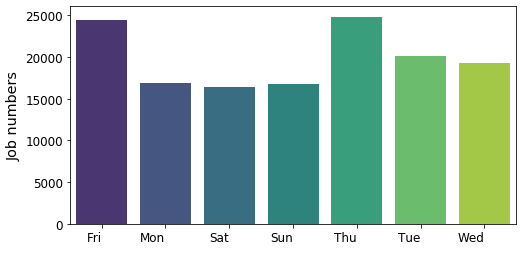

In [31]:
by_weekday = df_date_linkedin_trunc.groupby('Day of week').sum()
by_weekday.reset_index(inplace=True)
by_weekday

plt.figure(figsize=(8,4))
sns.barplot(x='Day of week', y='Jobnums', data=by_weekday, palette='viridis')
plt.xticks(horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='x-large')
plt.xlabel(' ')

## Combine with COVID-19 

In [32]:
df_covid_trunc = bydate_us['2020-06-12':'2020-08-02']

df_combined_linkedin = pd.concat([df_date_linkedin_trunc, df_covid_trunc], axis=1)
df_combined_linkedin

,Date,Jobnums,Day of week,Weekend,Confirmed,Deaths,Recovered,Active,New,Fatality
2020-06-12,2020-06-12,759,Fri,0,2048986.0,114669.0,547386.0,1386931.0,25639.0,5.596378
2020-06-13,2020-06-13,624,Sat,1,2074526.0,115436.0,556606.0,1402484.0,25540.0,5.564452
2020-06-14,2020-06-14,733,Sun,1,2094058.0,115732.0,561816.0,1416510.0,19532.0,5.526686
2020-06-15,2020-06-15,673,Mon,0,2114026.0,116127.0,576334.0,1421565.0,19968.0,5.493168
2020-06-16,2020-06-16,953,Tue,0,2137731.0,116963.0,583503.0,1437265.0,23705.0,5.471362
2020-06-17,2020-06-17,1540,Wed,0,2163290.0,117717.0,592191.0,1453382.0,25559.0,5.441573
2020-06-18,2020-06-18,1982,Thu,0,2191053.0,118438.0,599115.0,1473500.0,27763.0,5.405529
2020-06-19,2020-06-19,1625,Fri,0,2222812.0,119125.0,606715.0,1496972.0,31759.0,5.359203
2020-06-20,2020-06-20,1046,Sat,1,2255119.0,119719.0,617460.0,1517940.0,32307.0,5.308766
2020-06-21,2020-06-21,965,Sun,1,2281290.0,119977.0,622133.0,1539180.0,26171.0,5.259174


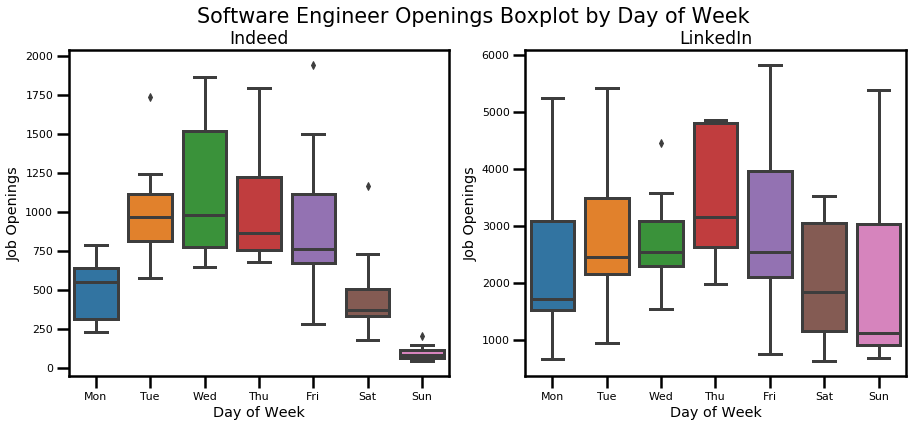

In [48]:
plt.figure(figsize=(15,6))
sns.set_context('poster',font_scale=0.5)
plt.subplot(121)
sns.boxplot(data=df_combined_indeed, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('Indeed', fontsize='x-large')
plt.subplot(122)
sns.boxplot(data=df_combined_linkedin, x='Day of week', y='Jobnums',order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('Job Openings', fontsize='large')
plt.xlabel('Day of Week', fontsize='large')
plt.title('LinkedIn', fontsize='x-large')
plt.suptitle('Software Engineer Openings Boxplot by Day of Week', fontsize='xx-large')
plt.show()

## Grid Search

In [33]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_linkedin[['New','Jobnums']], cfg_list, n_test, method)
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))
#model_summary = model_summary.append({'n_test':n_test, 'validation':method, 'data':'LinkedIn', 'model':'No eXog', 'best_param':scores[0][0], 'rmse':scores[0][1]},ignore_index=True)

---> Model[[(3, 0), 'n', 1]] 783.730
---> Model[[(3, 0), 'n', 2]] 874.350
---> Model[[(3, 0), 'c', 0]] 528.856
---> Model[[(3, 0), 'c', 1]] 739.376
---> Model[[(3, 0), 'c', 2]] 881.095
---> Model[[(3, 0), 'n', 0]] 548.569
---> Model[[(3, 0), 't', 0]] 681.190
---> Model[[(3, 0), 't', 1]] 795.899
---> Model[[(3, 0), 't', 2]] 909.042
---> Model[[(3, 0), 'ct', 0]] 421.356
---> Model[[(3, 0), 'ct', 1]] 953.071
---> Model[[(3, 0), 'ct', 2]] 905.063
---> Model[[(3, 1), 'n', 0]] 823.036
---> Model[[(3, 1), 'n', 1]] 856.188
---> Model[[(3, 1), 'n', 2]] 829.629
---> Model[[(3, 1), 'c', 0]] 703.122
---> Model[[(3, 1), 'c', 1]] 695.564
---> Model[[(3, 1), 'c', 2]] 933.407
---> Model[[(3, 1), 't', 0]] 594.827
---> Model[[(3, 1), 't', 1]] 697.781
---> Model[[(3, 1), 't', 2]] 1243.651
---> Model[[(3, 1), 'ct', 0]] 546.260
---> Model[[(3, 1), 'ct', 1]] 938.341
---> Model[[(3, 1), 'ct', 2]] 1269.069
---> Model[[(3, 2), 'n', 0]] 663.476
---> Model[[(3, 2), 'n', 1]] 1051.331
---> Model[[(3, 2), 'n', 2]] 

---> Model[[(9, 0), 'n', 2]] 1294.028
---> Model[[(9, 0), 'c', 0]] 652.747
---> Model[[(9, 0), 'c', 1]] 1147.571
---> Model[[(9, 0), 'c', 2]] 1292.835
---> Model[[(9, 0), 't', 0]] 1139.292
---> Model[[(9, 0), 't', 1]] 1162.077
---> Model[[(9, 0), 't', 2]] 1290.467
---> Model[[(9, 0), 'ct', 0]] 783.441
---> Model[[(9, 0), 'ct', 1]] 1221.688
---> Model[[(9, 0), 'ct', 2]] 1314.745
---> Model[[(9, 1), 'n', 0]] 885.906
---> Model[[(9, 1), 'n', 1]] 1276.760
---> Model[[(9, 1), 'n', 2]] 1345.300
---> Model[[(9, 1), 'c', 0]] 684.365
---> Model[[(9, 1), 'c', 1]] 1291.352
---> Model[[(9, 1), 'c', 2]] 1391.458
---> Model[[(9, 1), 't', 0]] 1010.490
---> Model[[(9, 1), 't', 1]] 1298.255
---> Model[[(9, 1), 't', 2]] 1277.277
---> Model[[(9, 1), 'ct', 0]] 811.418
---> Model[[(9, 1), 'ct', 1]] 1319.818
---> Model[[(9, 1), 'ct', 2]] 1342.652
---> Model[[(9, 2), 'n', 0]] 913.695
---> Model[[(9, 2), 'n', 1]] 1243.083
---> Model[[(9, 2), 'n', 2]] 1311.045
---> Model[[(9, 2), 'c', 0]] 794.033
---> Model[[(

In [45]:
best_cfg = [(3, 0), 'ct', 0]
n_test = 7
data = df_combined_linkedin[['New','Jobnums']]
train, test = train_test_split(data, n_test)
yhat_varma, error = walk_forward_best(data, n_test, best_cfg)

### X=Weekend

In [34]:
n_test = 7
cfg_list = varmax_configs()
method = 'walk'
scores = grid_search(df_combined_linkedin[['New','Jobnums']], cfg_list, n_test, method,exog=df_combined_linkedin[['Weekend']])
print('n_test:{}, method:{}, best_cfg parameters are:{}, rmse:{}'.format(n_test,method,scores[0][0],scores[0][1]))
#model_summary = model_summary.append({'n_test':n_test, 'validation':method, 'data':'LinkedIn', 'model':'X=weekend', 'best_param':scores[0][0], 'rmse':scores[0][1]},ignore_index=True)

---> Model[[(3, 0), 'c', 0]] 535.029
---> Model[[(3, 0), 'n', 1]] 969.227
---> Model[[(3, 0), 'n', 0]] 432.031
---> Model[[(3, 0), 'n', 2]] 948.870
---> Model[[(3, 0), 'c', 1]] 853.586
---> Model[[(3, 0), 'c', 2]] 1175.438
---> Model[[(3, 0), 't', 0]] 716.676
---> Model[[(3, 0), 't', 1]] 790.245
---> Model[[(3, 0), 't', 2]] 1156.755
---> Model[[(3, 0), 'ct', 0]] 540.940
---> Model[[(3, 0), 'ct', 1]] 1049.161
---> Model[[(3, 0), 'ct', 2]] 1145.359
---> Model[[(3, 1), 'n', 0]] 845.581
---> Model[[(3, 1), 'n', 1]] 1027.360
---> Model[[(3, 1), 'n', 2]] 945.278
---> Model[[(3, 1), 'c', 0]] 542.718
---> Model[[(3, 1), 'c', 1]] 1046.855
---> Model[[(3, 1), 'c', 2]] 1348.919
---> Model[[(3, 1), 't', 0]] 599.475
---> Model[[(3, 1), 't', 1]] 870.093
---> Model[[(3, 1), 't', 2]] 1296.112
---> Model[[(3, 1), 'ct', 0]] 545.363
---> Model[[(3, 1), 'ct', 1]] 1002.671
---> Model[[(3, 1), 'ct', 2]] 1148.710
---> Model[[(3, 2), 'n', 0]] 1225.679
---> Model[[(3, 2), 'n', 1]] 1107.995
---> Model[[(3, 2), 

---> Model[[(9, 0), 'n', 1]] 1274.935
---> Model[[(9, 0), 'n', 2]] 1264.660
---> Model[[(9, 0), 'c', 0]] 530.116
---> Model[[(9, 0), 'c', 1]] 1215.497
---> Model[[(9, 0), 'c', 2]] 1327.711
---> Model[[(9, 0), 't', 0]] 1288.540
---> Model[[(9, 0), 't', 1]] 1188.016
---> Model[[(9, 0), 't', 2]] 1304.344
---> Model[[(9, 0), 'ct', 0]] 1048.726
---> Model[[(9, 0), 'ct', 1]] 1244.929
---> Model[[(9, 0), 'ct', 2]] 1343.171
---> Model[[(9, 1), 'n', 0]] 1191.025
---> Model[[(9, 1), 'n', 1]] 1352.599
---> Model[[(9, 1), 'n', 2]] 1185.238
---> Model[[(9, 1), 'c', 0]] 574.308
---> Model[[(9, 1), 'c', 1]] 1435.088
---> Model[[(9, 1), 'c', 2]] 1347.951
---> Model[[(9, 1), 't', 0]] 998.843
---> Model[[(9, 1), 't', 1]] 1329.495
---> Model[[(9, 1), 't', 2]] 1318.517
---> Model[[(9, 1), 'ct', 0]] 982.812
---> Model[[(9, 1), 'ct', 1]] 1355.017
---> Model[[(9, 1), 'ct', 2]] 1254.887
---> Model[[(9, 2), 'n', 0]] 1278.388
---> Model[[(9, 2), 'n', 1]] 1422.238
---> Model[[(9, 2), 'n', 2]] 1314.446
---> Model

In [46]:
n_test = 7
best_cfg = [(3, 0), 'n', 0]
data = df_combined_linkedin[['New','Jobnums']]
train, test = train_test_split(data, n_test)
yhat_varmax, errorx = walk_forward_best(data, n_test, best_cfg, exog=df_combined_linkedin[['Weekend']])

In [49]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"colspan": 2}, None],[{}, {}]],
    subplot_titles=("Train data",'No eXog, RMSE: {:0.2f}'.format(error), 'X=Weekend, RMSE: {:0.2f}'.format(errorx)))

fig.add_trace(go.Scatter(x=train.index, y=train['Jobnums'], mode='lines+markers',name='Train', showlegend=False), row=1, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers',line=dict(color='green'), name='Test', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=yhat_varma["Jobnums"], mode='lines+markers',line=dict(color='red'), name='Prediction',showlegend=False),row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,1], fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=1)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_ci.iloc[:,3], fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=1)
fig.add_trace(go.Scatter(x=test.index, y=test['Jobnums'], mode='lines+markers', line=dict(color='green'), name='Test',showlegend=True), row=2, col=2)
fig.add_trace(go.Scatter(x=test.index, y=yhat_varmax["Jobnums"], mode='lines+markers', line=dict(color='red'), name='Prediction',showlegend=True),row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_u, fill=None, mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False), row=2, col=2)
#fig.add_trace(go.Scatter(x=pred_cix.index, y=pred_l, fill='tonexty', mode='lines',line=dict(width=0.0,color='lightgray'),showlegend=False),row=2, col=2)
fig.update_layout(title='LinkedIn Software Engineer Job Openings Forecast via VARMAX Model',legend=dict(x=1,y=0.25))
fig.show()

### Future Forecast

In [57]:
df_linkedin_future = pd.DataFrame(columns=['Date', 'Day of week', 'Weekend'])
df_linkedin_future['Date'] = pd.date_range('2020-08-03', '2020-08-09')
df_linkedin_future.set_index('Date', inplace=True, drop=False)
df_linkedin_future['Day of week'] = df_indeed_future['Date'].apply(lambda x: week[x.weekday()])
df_linkedin_future['Weekend'] = df_indeed_future['Day of week'].apply(lambda x: 1 if (x=='Sun') or (x=='Sat') else 0)
df_linkedin_future

,Date,Day of week,Weekend
Date,,,
2020-08-03,2020-08-03,Mon,0
2020-08-04,2020-08-04,Tue,0
2020-08-05,2020-08-05,Wed,0
2020-08-06,2020-08-06,Thu,0
2020-08-07,2020-08-07,Fri,0
2020-08-08,2020-08-08,Sat,1
2020-08-09,2020-08-09,Sun,1


In [58]:
n_test = 7
best_cfg = [(3, 0), 'n', 0]
train = df_combined_linkedin[['New','Jobnums']]
exog_train = df_combined_linkedin[['Weekend']]
exog_test = df_linkedin_future[['Weekend']]
linkedin_pred = pd.DataFrame()
history = train.copy()
exog_ = [x[:] for x in exog_train.values]
for i in range(n_test):
    yhat = varmax_forecast(history, 1, best_cfg, exog1=exog_, exog2=np.array(exog_test.iloc[i]).reshape(1,-1))
    linkedin_pred = linkedin_pred.append(yhat)
    history = history.append(yhat)
    exog_.append(np.array(exog_test.iloc[i]))

In [62]:
fig = go.Figure()

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0=df_linkedin_future.index[0],
            y0=0,
            x1=df_linkedin_future.index[-1],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.2,
            layer="below",
            line_width=0,
        )
    ]
)

fig.add_trace(go.Scatter(x=df_combined_linkedin.index, y=df_combined_linkedin['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='royalblue'), name='Train'))

fig.add_trace(go.Scatter(x=df_linkedin_future.index, y=linkedin_pred['Jobnums'], mode='lines+markers', 
                         marker=dict(size=8, color='red'), name='Future Forecast'))


fig.add_annotation(
            x='2020-08-06',
            y=3600,
            text="Future<br>forecast",
            font=dict(size=16),
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            ax=10,
            ay=-70,)

fig.update_layout(title={'text': "LinkedIn Software Engineer Open Positions Future Forecast (VARMAX Model)", 
                         'y':0.9, 'x':0.52,
                         'xanchor': 'center',
                         'yanchor': 'top'},
                  width=900,
                  height=500,
                  titlefont=dict(size=20),
                  xaxis=dict(title=dict(text='Post date', standoff=0), titlefont=dict(size=18), tickfont=dict(size=16)),
                  yaxis=dict(title=dict(text='Job numbers'), titlefont=dict(size=18), tickfont=dict(size=16)),
                  legend=dict(font=dict(size=16), x=0.05, y=0.95),
                  margin = {'r':10, 'l': 0, 't':90, 'b':0}
                 )
fig.show()